# `GRF potential inhomogeneties inference` starting guide

This notebook shows basic examples of using _Herculens_ for lensing simulation, checking distributions of random variables, example of grid search-based GRF inference and gradient descent-based GRF inference.

__Notebook author__: @egorssed

__Herculens authors__: @austinpeel, @aymgal

__last updated__: 31/01/22

In [89]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
plt.style.use('default')

# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Fontsize
FS=18

# Observed image

Let's assume that we used HST for lens finding and we observed the following perturbed Einstein ring.  
Our goal is to infer the statistical properties of these perturbations. (spoiler $A=-7.6$ , $\beta=2$)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_43202/1947474764.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


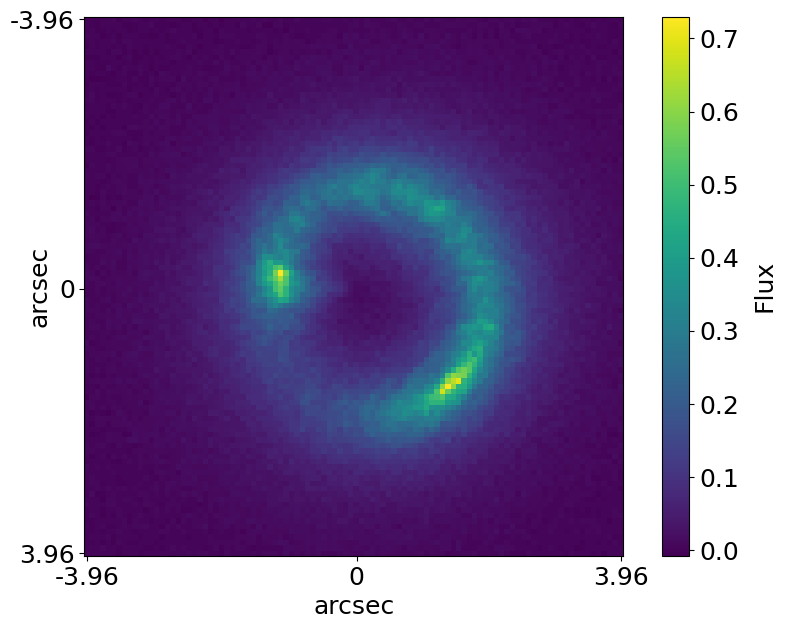

In [90]:
#Observation conditions
PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure time for Poisson noise
SNR=200 #75th percentile of COSMOS dataset's distribution of Peak-SNR for Background noise  

#Observed image
Observed_image=np.load('./data/Observation example.npy')

#Figure
fig,axis=plt.subplots(1,1,figsize=(10,7))
img=axis.imshow(Observed_image)
cbar=fig.colorbar(img,ax=axis,fraction=0.045)
cbar.ax.tick_params(labelsize=FS)
cbar.ax.set_ylabel('Flux',rotation=90,fontsize=FS,labelpad=10)
axis.set_xticks([0,50,100-1])
axis.set_xticklabels([-3.96,0,3.96],fontsize=FS)
axis.set_yticks([0,50,100-1])
axis.set_yticklabels([-3.96,0,3.96],fontsize=FS)
axis.set_xlabel('arcsec',fontsize=FS)
axis.set_ylabel('arcsec',fontsize=FS,labelpad=-30)
fig.show()

## Inference of unperturbed Einstein ring parameters

First thing that we need to do is to infer parameters of source's surface brightness and parameters of unperturbed lens gravitational potential

In [91]:
#A class with all the functionality for lens simulation
from GRF_perturbations.Modules.Data_generation import Observation_conditions_class
#A class with all the functionality for Source-lens inference and GRF potential perturbations inference
from GRF_perturbations.Modules.Inference import Inference_class

### Pixel grid

In [92]:
from herculens.Coordinates.pixel_grid import PixelGrid

pixel_number=100 #The grids are 100x100 pixel squares
supersampling_factor=1 #The lens plane and the source plane grids have the same discretization
pixel_scale=0.08 #The resolution is 0.08 arcsec/pixel

half_size = pixel_number * pixel_scale / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pixel_scale / 2
transform_pix2angle = pixel_scale * np.eye(2)
kwargs_pixel = {'nx': pixel_number, 'ny': pixel_number,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

#Grid coordinates
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]

## unperturbed Einstein ring model

In this section we will fit the perturbed Einstein ring with unperturbed ring model to infer the parameters of source and unperturbed lens.  
For this we need to predefine priors of the parameters and initial guess.  
Priors were taken from the article Park et al. 2021 Table 1 (Partially). Initial guess is somewhat mean of the priors

In [93]:
#Source's surface brightness
source_light_model_list = ['SERSIC_ELLIPSE']

#Lens' gravitational potential
#Models for the lens galaxy, other objects along the line of sight and for GRF potential perturbations correspondingly
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED'] 

#We consider no lens light in this research (unphysical but adding it won't change a lot in the inference)
lens_light_model_list = []
kwargs_lens_light=[{}]

#Annulus radii covering the Einstein ring (arcsec)
annulus_mask_borders=[0.5,3]

#Class for rings simulation 
Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time,supersampling_factor,\
                                                    source_light_model_list=source_light_model_list,\
                                                    lens_mass_model_list=lens_mass_model_list,\
                                                    lens_light_model_list=lens_light_model_list,\
                                                    annulus_mask_borders=annulus_mask_borders)

#Class for simulation and inference of GRF 
model_kwargs=Observation_conditions.kwargs_data #unpertubed model parameters used as initial guess of 
GRF_seeds_number=100
SL_fitting_max_iter=1000; SL_fitting_learning_rate=5e-4

#Define the class for simulation and inference of GRF
Inference=Inference_class(Observation_conditions,model_kwargs,GRF_seeds_number,SL_fitting_max_iter,SL_fitting_learning_rate)

Precomputing Fourier phases
Precompiling source-lens loss,gradient,hessian
Precomputing loss
Precomputing loss gradient
Precomputing loss hessian
Inference class is ready


The compilation takes so long because it precompiles graphs for gradient and hessian of the unperturbed and perturbed models. These graphs will be used afterwards for the Einstein ring model inference and GRF potential perturbations inference.

In [94]:
def show_model_params(model):
    for lens in model:
        for key in lens:
            value=lens[key]
            if isinstance(value, list):
                value=value.item()
            print(key,': ',round(value,3))


init_kwargs=Observation_conditions.parameters.args2kwargs(Observation_conditions.parameters.initial_values())
print('Initial lens mass SIE+Shear model: \n')
show_model_params(init_kwargs['kwargs_lens'])
print('\nInitial source light Elliptic Sercic model: \n')
show_model_params(init_kwargs['kwargs_source'])
#print('\nInitial source light model: ',init_kwargs['kwargs_source'])

Initial lens mass SIE+Shear model: 

theta_E :  1.5
e1 :  0.001
e2 :  0.001
center_x :  0.001
center_y :  0.001
gamma1 :  0.001
gamma2 :  0.001
ra_0 :  0.0
dec_0 :  0.0

Initial source light Elliptic Sercic model: 

amp :  5.0
R_sersic :  2.5
n_sersic :  2.0
e1 :  0.001
e2 :  0.001
center_x :  0.0
center_y :  0.0


The initial values are just mean values of the prior. The priors were taken from Park et al. 2021 Table 1 (Partially)

In [95]:
#Fit the image with unperturbed Einstein ring model to infer the source and the unperturbed lens parameters
args_fit=Inference.scipy_fit_image(Observed_image,method='trust-krylov')
kwargs_fit=Observation_conditions.parameters.args2kwargs(args_fit)

print('Fit lens mass SIE+Shear model: \n')
show_model_params(kwargs_fit['kwargs_lens'])

print('\Fit source light Elliptic Sercic model: \n')
show_model_params(kwargs_fit['kwargs_source'])

Fit lens mass SIE+Shear model: 

theta_E :  1.597
e1 :  0.154
e2 :  -0.038
center_x :  -0.01
center_y :  0.003
gamma1 :  -0.007
gamma2 :  0.032
ra_0 :  0.0
dec_0 :  0.0
\Fit source light Elliptic Sercic model: 

amp :  10.142
R_sersic :  1.193
n_sersic :  1.474
e1 :  0.062
e2 :  -0.101
center_x :  0.396
center_y :  0.151


In [96]:
kwargs_true={'kwargs_lens': [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                             {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}],
             'kwargs_source': [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}],
             'kwargs_lens_light': [{}]}

print('Spoiler: The true parameters are\n')
print('Galaxy potential:',kwargs_true['kwargs_lens'][0])
print('External shear potential',kwargs_true['kwargs_lens'][1])
print('Source surface brightness',kwargs_true['kwargs_source'][0])

Spoiler: The true parameters are

Galaxy potential: {'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0}
External shear potential {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}
Source surface brightness {'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15, 'e1': 0.07, 'e2': -0.1}


We see some deviations between true and fit parameters, but those are quite minor.

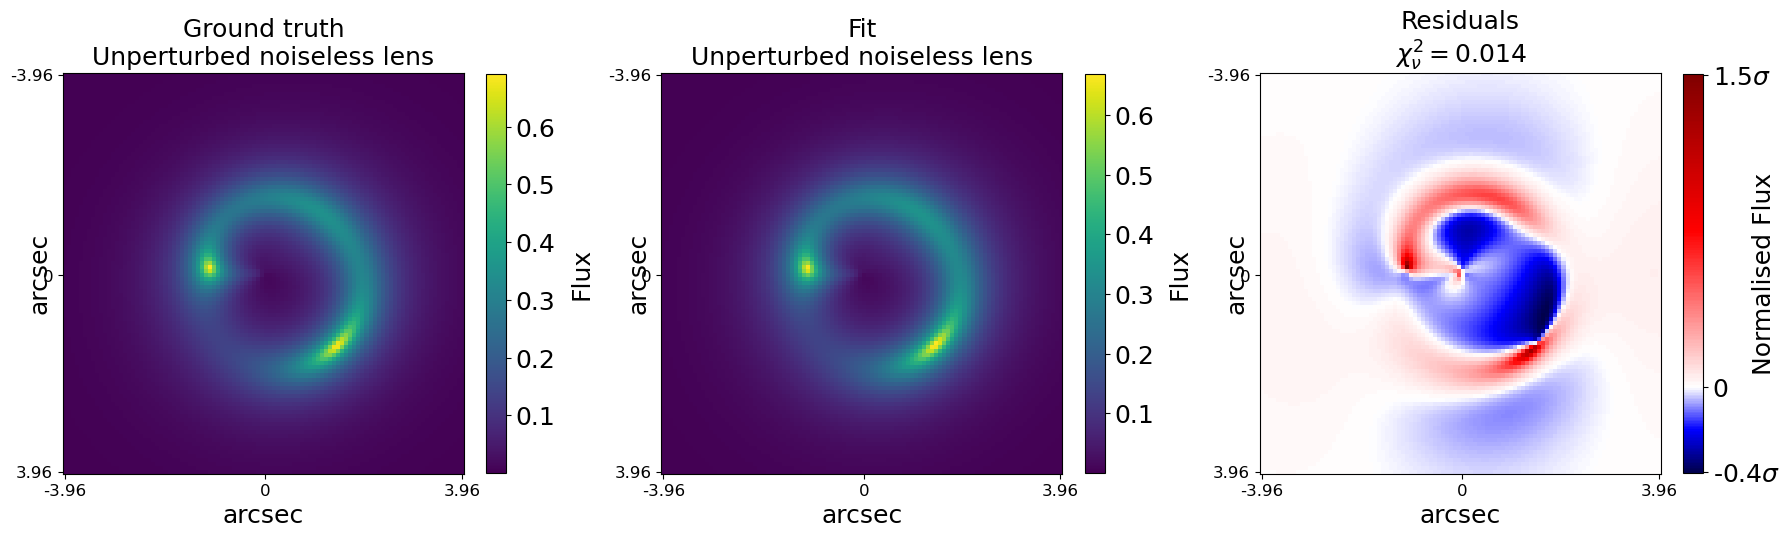

In [97]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter

fit_image=simulate_unperturbed_image(kwargs_fit,Noise_flag=False)
true_image=simulate_unperturbed_image(kwargs_true,Noise_flag=False)
fit_residuals=(true_image-fit_image)/np.sqrt(Observation_conditions.noise_var)
colorborders=[math.ceil(fit_residuals.min()*1e+1)/1e+1,0,math.floor(fit_residuals.max()*1e+1)/1e+1]

fig,ax=plt.subplots(1,3,figsize=(18,7))

img_arr=[]

img_arr+=[ax[0].imshow(true_image)]
cbar=fig.colorbar(img_arr[0],ax=ax[0],fraction=0.045)
cbar.ax.tick_params(labelsize=FS)
cbar.ax.set_ylabel('Flux',rotation=90,fontsize=FS,labelpad=10)

img_arr+=[ax[1].imshow(fit_image)]
cbar=fig.colorbar(img_arr[1],ax=ax[1],fraction=0.045)
cbar.ax.tick_params(labelsize=FS)
cbar.ax.set_ylabel('Flux',rotation=90,fontsize=FS,labelpad=10)

img_arr+=[ax[2].imshow(fit_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
cbar=fig.colorbar(img_arr[2],ax=ax[2],ticks=[math.ceil(fit_residuals.min()*1e+2)/1e+2,0,math.floor(fit_residuals.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=FS,labelpad=-20)
cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'],fontsize=FS)

titles=['Ground truth\nUnperturbed noiseless lens','Fit\nUnperturbed noiseless lens','Residuals\n'+r'$\chi^2_{\nu}=$'+'{:.3f}'.format((fit_residuals**2).sum()/(fit_residuals.size-1))]

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.set_xticks([0,50,100-1])
    axis.set_xticklabels([ra_at_xy_0,0,-ra_at_xy_0],fontsize=12)
    axis.set_yticks([0,50,100-1])
    axis.set_yticklabels([ra_at_xy_0,0,-ra_at_xy_0],fontsize=12)
    axis.set_xlabel('arcsec',fontsize=FS)
    axis.set_ylabel('arcsec',fontsize=FS,labelpad=-30)

plt.tight_layout()
#plt.show()

## Surface brightness anomalies

In [98]:
#Redefine classes considering that the fit parameters are the actual ones.
unperturbed_lens_mass=list(np.append(kwargs_fit['kwargs_lens'],[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': np.zeros_like(x_coords)}]))
Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time,supersampling_factor,\
                                                    source_light_model_list=source_light_model_list,kwargs_source_light=kwargs_fit['kwargs_source'],\
                                                    lens_mass_model_list=lens_mass_model_list,kwargs_lens_mass=unperturbed_lens_mass,\
                                                    lens_light_model_list=lens_light_model_list,\
                                                    annulus_mask_borders=annulus_mask_borders)

#ReDefine the class for simulation and inference of GRF
Inference=Inference_class(Observation_conditions,model_kwargs,GRF_seeds_number,SL_fitting_max_iter,SL_fitting_learning_rate)

Precomputing Fourier phases
Precompiling source-lens loss,gradient,hessian
Precomputing loss
Precomputing loss gradient
Precomputing loss hessian
Inference class is ready


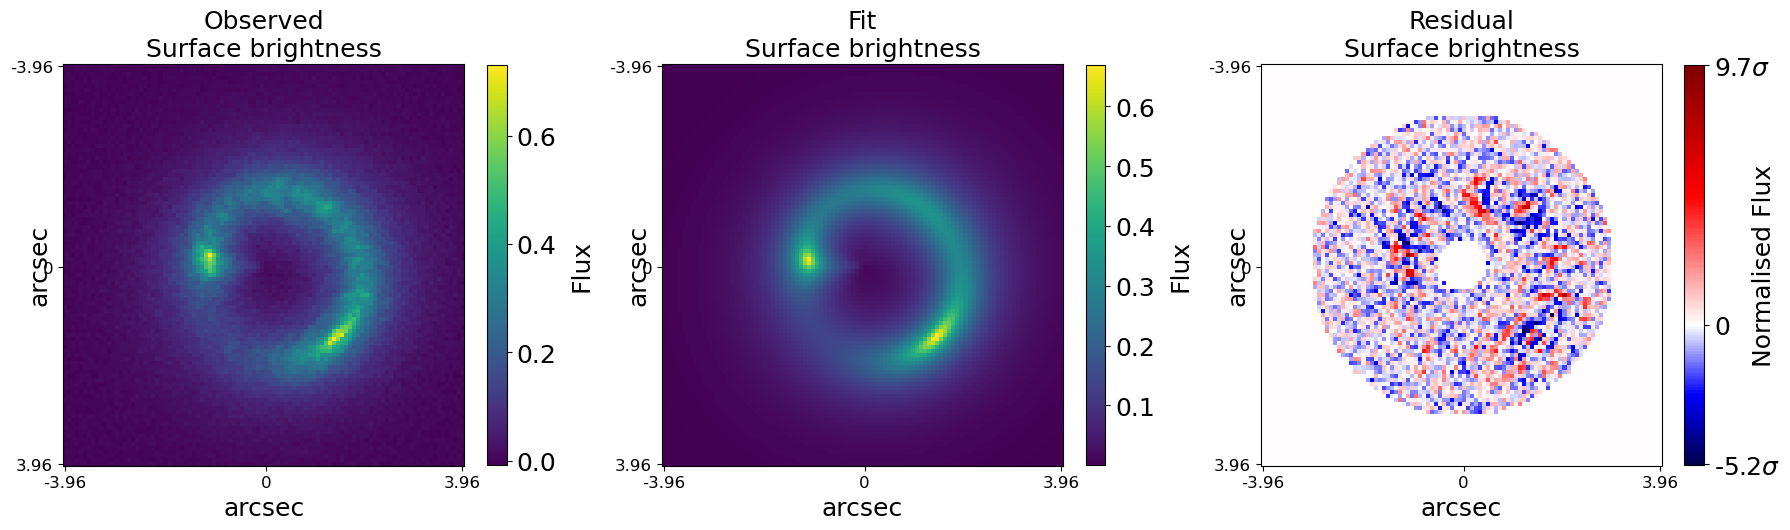

In [99]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)

normalised_masked_residuals=((Observed_image-Image_unperturbed_noiseless)*Observation_conditions.annulus_mask)/np.sqrt(Observation_conditions.noise_var)
colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]

fig,ax=plt.subplots(1,3,figsize=(18,7))

img_arr=[]

img_arr+=[ax[0].imshow(Observed_image)]
cbar=fig.colorbar(img_arr[0],ax=ax[0],fraction=0.045)
cbar.ax.tick_params(labelsize=FS)
cbar.ax.set_ylabel('Flux',rotation=90,fontsize=FS,labelpad=10)

img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
cbar=fig.colorbar(img_arr[1],ax=ax[1],fraction=0.045)
cbar.ax.tick_params(labelsize=FS)
cbar.ax.set_ylabel('Flux',rotation=90,fontsize=FS,labelpad=10)

img_arr+=[ax[2].imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
cbar=fig.colorbar(img_arr[2],ax=ax[2],ticks=[math.ceil(normalised_masked_residuals.min()*1e+2)/1e+2,0,math.floor(normalised_masked_residuals.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=FS,labelpad=-20)
cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'],fontsize=FS)

titles=['Observed\nSurface brightness','Fit\nSurface brightness','Residual\nSurface brightness']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.set_xticks([0,50,100-1])
    axis.set_xticklabels([ra_at_xy_0,0,-ra_at_xy_0],fontsize=12)
    axis.set_yticks([0,50,100-1])
    axis.set_yticklabels([ra_at_xy_0,0,-ra_at_xy_0],fontsize=12)
    axis.set_xlabel('arcsec',fontsize=FS)
    axis.set_ylabel('arcsec',fontsize=FS,labelpad=-30)

plt.tight_layout()
#plt.show()

One can see the residual image the impact of the anomalies as well as the impact of the noise. In the first order Taylor approximation:  
Relation between potential perturbations and surface brightness anomalies without noise:  
$\delta I(\vec{x})=-\left.\frac{d S(\vec{y})}{d\vec{y}}\right|_{\vec{x}-\vec{\nabla}\psi(\vec{x)}} \cdot \vec{\nabla} \delta \psi (\vec{x})+...$  
Distribution of the anomalies with noise:  
$\delta I(\vec{x}) \sim \mathcal{N}(\mu_{pert}(\vec{x}),\sigma^2_{pert}(\vec{x}))+\mathcal{N}(0,\sigma^2_{obs}(\vec{x}))+...$

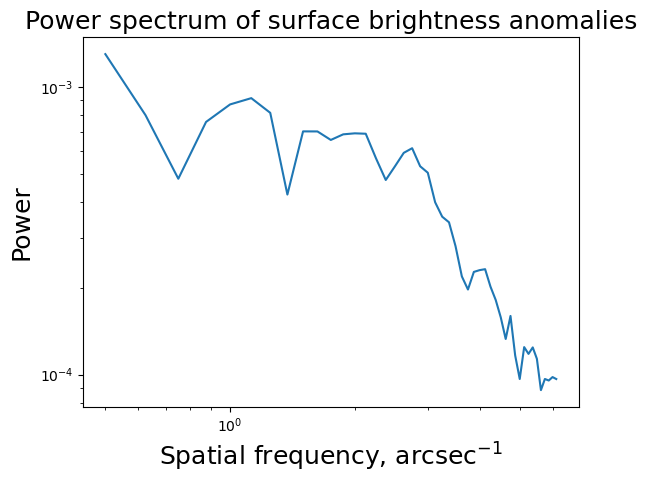

In [100]:
data_spectrum=Inference.compute_radial_spectrum(Observed_image-Image_unperturbed_noiseless)
plt.loglog(Observation_conditions.frequencies,data_spectrum)
plt.xlabel('Spatial frequency, arcsec'+r'$^{-1}$',fontsize=FS)
plt.ylabel('Power',fontsize=FS)
plt.title('Power spectrum of surface brightness anomalies',fontsize=FS)
plt.show()

# Grid search-based inference

In order to infer the original parameters of the potential perturbations one should precompute the tensor of power spectra for all the possible combinations of $A$ and $\beta$.  
$\mathcal{P}_{A,\beta,\phi,k} = \mathcal{R}^{N_{A} \times N_{\beta} \times N_{\phi} \times N_{k}}$

You can find scripts for these computation in the following folder:

In [33]:
!ls ../Processing_scripts/Lesta_scripts

Anomalies_grid.py       start0_Anomalies.slurm
Anomalies_to_Spectra.py start_Spec.slurm


In [38]:
from GRF_perturbations.Modules.Jax_Utils import jax_map #a mapping of function over an array in a jaxified manner

#These two functions combined will give you the anomalies radial spectrum for given A,beta,phi. These were used in the scripts.
#We will estimate the results for one combination with the correct A,beta parameters, but wrong phase, just for demonstration purpose

def Compute_anomalies(Inference,GRF_params,Fourier_phase,Noise=True):
    get_GRF=Inference.GRF_getters(False)

    GRF_potential=get_GRF(GRF_params,Fourier_phase)

    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(Fourier_phase[0,1].real*(1e+3)+1)*1e+5)).astype(int)

    simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
    simulated_image=simulate_perturbed_image(GRF_potential,Inference.Observation_conditions.kwargs_data,Noise,noise_seed)

    args_fit=Inference.differentiable_fit_image(simulated_image)
    simulate_unperturbed_image=Inference.Observation_conditions.unperturbed_image_getter
    fit_image=simulate_unperturbed_image(Inference.Observation_conditions.parameters.args2kwargs(args_fit),Noise_flag=False)
    residuals=simulated_image-fit_image
    return residuals
    
def anomalies_to_radial_spectrum(anomaly_image, Observation_conditions, k_grid):
    radial_spectrum = Inference.compute_radial_spectrum(anomaly_image)
    return radial_spectrum

def compute_spectrum(GRF_params,Fourier_phase,Observation_conditions,Inference,k_grid):
    anomalies=Compute_anomalies(Inference,GRF_params,Fourier_phase)
    spectrum=anomalies_to_radial_spectrum(anomalies,Observation_conditions,k_grid)
    return spectrum

from GRF_perturbations.Modules.GRF_generation import get_k_grid
k_grid, _ = get_k_grid(Observation_conditions.pixel_number, Observation_conditions.pixel_scale)

compute_spectrum_pure=lambda logA,Beta,Fourier_phase: compute_spectrum(jnp.array([logA,Beta]),Fourier_phase,Observation_conditions,Inference,k_grid)
compute_spectrum_seeds= lambda logA,Beta: jax_map(lambda Fourier_phase: compute_spectrum_pure(logA,Beta,Fourier_phase),Inference.Fourier_phase_tensor)
    

start_time=time.time()
#an image of anomalies for the correct GRF spectrum parameters, but wrong GRF phase
simulated_anomaly=Compute_anomalies(Inference,[-7.6,2],Inference.Fourier_phase_tensor[0],Noise=True)
#a set of 100 anomalies radial power spectra for correct GRF parameters
simulated_spectra=compute_spectrum_seeds(-7.6,2)
print('Time: {:.0f} seconds'.format(time.time()-start_time))

Time: 122 seconds


In [40]:
simulated_spectra.shape

(100, 46)

### Here you can see an example of simulated anomalies. These have correct statistical parameters, but deliberately incorrect phase

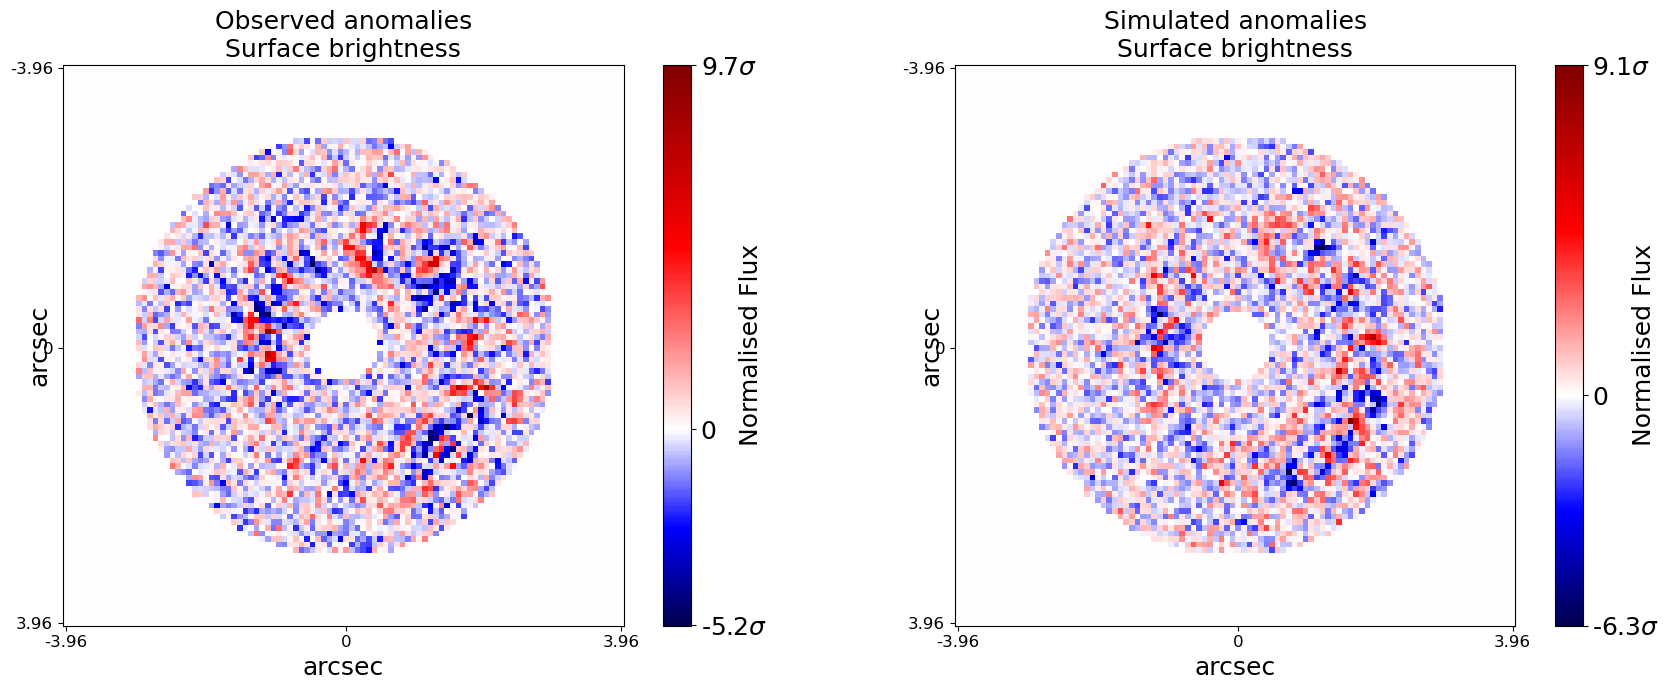

In [42]:
fig,ax=plt.subplots(1,2,figsize=(18,7))

img_arr=[]

normalised_masked_residuals=((Observed_image-Image_unperturbed_noiseless)*Observation_conditions.annulus_mask)/np.sqrt(Observation_conditions.noise_var)
colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]

img_arr+=[ax[0].imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
cbar=fig.colorbar(img_arr[0],ax=ax[0],ticks=[math.ceil(normalised_masked_residuals.min()*1e+2)/1e+2,0,math.floor(normalised_masked_residuals.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=FS,labelpad=-20)
cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'],fontsize=FS)

normalised_simulated_masked_residuals=((simulated_anomaly)*Observation_conditions.annulus_mask)/np.sqrt(Observation_conditions.noise_var)
colorborders=[math.ceil(normalised_simulated_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_simulated_masked_residuals.max()*1e+1)/1e+1]

img_arr+=[ax[1].imshow(normalised_simulated_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
cbar=fig.colorbar(img_arr[1],ax=ax[1],ticks=[math.ceil(normalised_simulated_masked_residuals.min()*1e+2)/1e+2,0,math.floor(normalised_simulated_masked_residuals.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=FS,labelpad=-20)
cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'],fontsize=FS)

titles=['Observed anomalies\nSurface brightness','Simulated anomalies\nSurface brightness']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.set_xticks([0,50,100-1])
    axis.set_xticklabels([ra_at_xy_0,0,-ra_at_xy_0],fontsize=12)
    axis.set_yticks([0,50,100-1])
    axis.set_yticklabels([ra_at_xy_0,0,-ra_at_xy_0],fontsize=12)
    axis.set_xlabel('arcsec',fontsize=FS)
    axis.set_ylabel('arcsec',fontsize=FS,labelpad=-30)

plt.tight_layout()
#plt.show()

### As you can see, anomalies radial power spectrum follow distribution that is indeed close to logNormal

In [46]:
#Mean of logNormal distribution of anomalies Power spectrum 
Mu_logN=np.log(simulated_spectra).mean(axis=0)
MU_tensor_ext=np.tile(Mu_logN,GRF_seeds_number)
MU_tensor_ext=MU_tensor_ext.reshape((GRF_seeds_number,simulated_spectra.shape[-1]))
#Std of the LogNormal distribution
Sigma_logN=np.sqrt(np.power(np.log(simulated_spectra)-MU_tensor_ext,2).sum(axis=0)/(simulated_spectra.shape[0]-1))

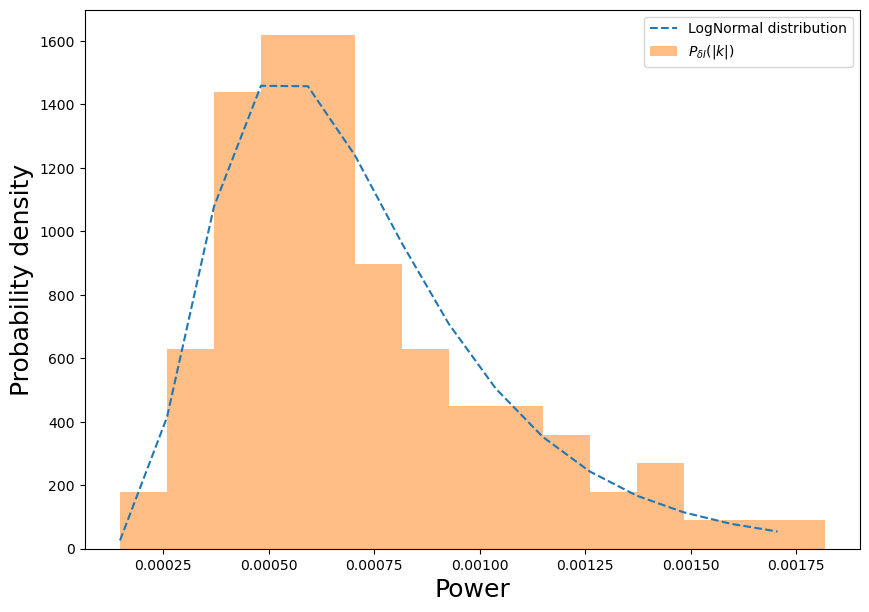

In [66]:
from scipy.stats import lognorm
import scipy as sc
plt.figure(figsize=(10,7))


index_freq=4
index_rad=index_freq+1-4

index_A=95
index_B=50

data=simulated_spectra[:,index_rad]

#1<=k<1.125
distr_marg,x_marg=np.histogram(data,bins=15,density=True)
plt.hist(data,bins=15,density=True,label=r'$P_{\delta I}(|k|)$',color='C1',alpha=0.5)


LN_mu=Mu_logN[index_rad]
LN_sigma=Sigma_logN[index_rad]
plt.plot(x_marg[:-1],lognorm.pdf(x_marg[:-1],s=LN_sigma,loc=0,scale=np.exp(LN_mu)),label='LogNormal distribution',linestyle='--',color='C0')

plt.xlabel('Power',fontsize=FS)
plt.ylabel('Probability density',fontsize=FS)
plt.legend()
plt.show()

### So model of log(Power) with Gaussian errors is quite a good discription

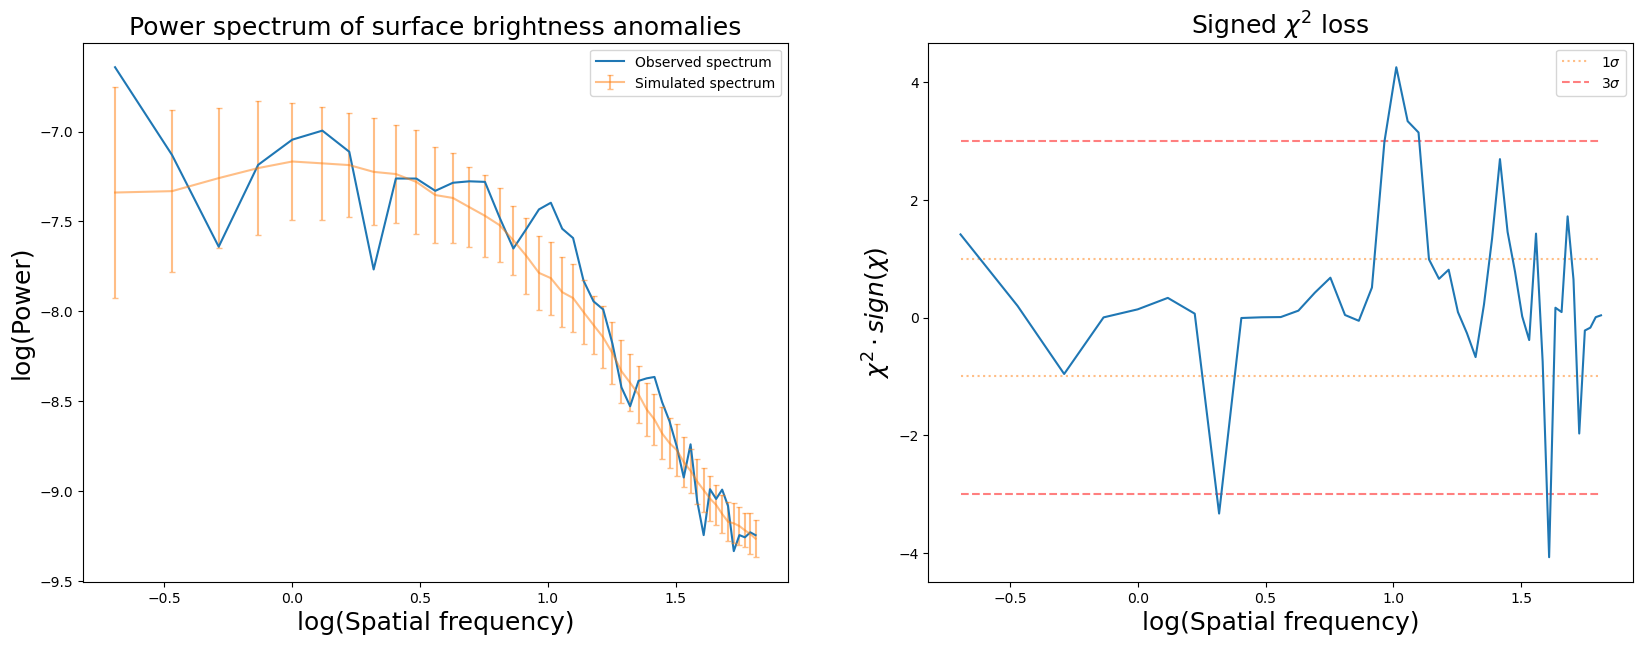

In [88]:
fig,ax=plt.subplots(1,2,figsize=(20,7))

x=np.log(Observation_conditions.frequencies)
y=np.log(data_spectrum)

ax[0].plot(x,y,label='Observed spectrum')
ax[0].errorbar(x,Mu_logN,Sigma_logN,capsize=2,alpha=0.5,label='Simulated spectrum')
ax[0].set_ylabel('log(Power)',fontsize=FS)
ax[0].set_title('Power spectrum of surface brightness anomalies',fontsize=FS)


signed_chi_sq=np.sign(y-Mu_logN)*((y-Mu_logN)/Sigma_logN)**2
ax[1].plot(x,signed_chi_sq)
ax[1].set_ylabel(r'$\chi^2 \cdot sign(\chi)$',fontsize=FS)
ax[1].set_title('Signed '+r'$\chi^2$'+' loss',fontsize=FS)
ax[1].hlines([-1,1],x[0],x[-1],color='C1',linestyle='dotted',alpha=0.5,label=r'$1\sigma$')
ax[1].hlines([-3,3],x[0],x[-1],color='r',linestyle='dashed',alpha=0.5,label=r'$3\sigma$')




for i in range(2):
    ax[i].set_xlabel('log(Spatial frequency)',fontsize=FS)
    ax[i].legend()
plt.show()

### At the previous stage we computed library for the correct combination of A,$\beta$, however in the real case one has to compute such a library for all the combinations. Here we use the one preconputed for the studied lens

In [12]:
from GRF_perturbations.Modules.Inference import infer_LogNorm_params,Inference_pipeline,compute_SNR_grid,plot_likelihood,get_conf_intervals,Spectra_Loss,compute_Loss_grid

grid_size=128
logA_array=np.linspace(-10.075,-6.9,grid_size)
Beta_array=np.linspace(0,4.7,grid_size)
GRF_seeds_number=100

#The grid computed for the parameters above
Spectra_grid=np.load('../Processing_scripts/results/Radial_spectra/Spectra_grid.npz')['arr_0']

#Noise properties
noise_var=Observation_conditions.noise_var
parameters=Observation_conditions.parameters
Estimated_Noise_spectral_density=(noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()
#Map of SNRs for all the A,beta combinations
SNR_grid=compute_SNR_grid(Spectra_grid,Estimated_Noise_spectral_density)

/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Inference.py:227: RuntimeWarning: invalid value encountered in log10
  SNR=10*np.log10(np.mean(Spectra_grid-Noise_spectral_density,axis=-1)/Noise_spectral_density)


In [13]:
#Statistics of the spectra
MU_tensor=np.log(Spectra_grid).mean(axis=2)
MU_tensor_ext=np.tile(MU_tensor,GRF_seeds_number)
MU_tensor_ext=MU_tensor_ext.reshape((grid_size,grid_size,GRF_seeds_number,Spectra_grid.shape[-1]))
Sigma_tensor=np.sqrt(np.power(np.log(Spectra_grid)-MU_tensor_ext,2).sum(axis=2)/(Spectra_grid.shape[2]-1))

In [91]:
y_labels=np.round(logA_array,2)
x_labels=np.round(Beta_array,2)

num_ticks = 8
# the index of the position of yticks
ticks = np.linspace(0, len(logA_array) - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)

def set_labels_plt(fontsize):
    plt.gca().set_yticklabels(yticklabels,fontsize=fontsize)
    plt.gca().set_xticklabels(xticklabels,fontsize=fontsize)
    
def plot_line(ax_row,data_image,residuals_image,GRF_potential,likelihood,Confidence_grid,SNR,\
              true_logA_index,true_Beta_index,pred_logA_index,pred_Beta_index,ylabel,manual_locations,\
              logA_ind_lim=(0,160),Beta_ind_lim=(0,214),legend_flag=True,titles_flag=True):
    #Data
    im=ax_row[0].imshow(data_image)
    cbar=fig.colorbar(im,ax=ax_row[0],ticks=[0,math.floor(data_image.max()*100)/100],fraction=0.045)
    cbar.ax.set_yticklabels(['0','{:.1f}'.format(math.floor(data_image.max()*100)/100)],fontsize=FS)
    cbar.ax.set_ylabel('Flux',rotation=90,fontsize=FS,labelpad=-20)
    
    #Potential
    im=ax_row[1].imshow(GRF_potential,cmap='Spectral',norm=mpl.colors.TwoSlopeNorm(0))
    cbar=fig.colorbar(im,ax=ax_row[1],ticks=[math.ceil(GRF_potential.min()*1e+3)/1e+3,0,math.floor(GRF_potential.max()*1e+3)/1e+3],fraction=0.045)
    cbar.ax.set_ylabel('Potential',rotation=90,fontsize=FS,labelpad=-20)
    #if (GRF_potential.min()<-0.01) and (GRF_potential.max()>0.01):
    #    cbar.ax.set_yticklabels(['{:.2f}'.format(math.ceil(GRF_potential.min()*1e+3)/1e+3),'0','{:.2f}'.format(math.floor(GRF_potential.max()*1e+3)/1e+3)],fontsize=FS)
    #else:
    cbar.ax.set_yticklabels(['{:.3f}'.format(math.ceil(GRF_potential.min()*1e+3)/1e+3),'0','{:.3f}'.format(math.floor(GRF_potential.max()*1e+3)/1e+3)],fontsize=FS)
    
    #masked_resid=resids_images[i]*mask
    #norm_masked_resid=(resids_images[i]/np.sqrt(noise_vars[i]))*mask
    
    #Residuals
    normalised_masked_residuals=(residuals_image*Observation_conditions.annulus_mask)/np.sqrt(noise_var)
    colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]
    
    
    im=ax[i,2].imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    cbar=fig.colorbar(im,ax=ax_row[2],ticks=colorborders,fraction=0.045)
    cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=FS,labelpad=-20)
    cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'],fontsize=FS)
    #fig.colorbar(im,ax=ax[i,2],ticks=[math.ceil(resids_images[i].min()*1e+3)/1e+3,0,math.floor(resids_images[i].max()*1e+3)/1e+3],fraction=0.045)
    
    
    Crop_Beta_arr=Beta_array[Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_logA_arr=logA_array[logA_ind_lim[0]:logA_ind_lim[1]]
    Crop_likelihood=likelihood[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_confidence=Confidence_grid[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_SNR=SNR[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    
    
    Like_xticks=np.arange(10)
    Like_xticks=Like_xticks[np.where( (Like_xticks>=Crop_Beta_arr[0]) & (Like_xticks<=Crop_Beta_arr[-1]) )[0]]
    Like_yticks=np.arange(0,7)*0.5-10
    Like_yticks=Like_yticks[np.where( (Like_yticks>=Crop_logA_arr[0]) & (Like_yticks<=Crop_logA_arr[-1]) )[0]]
    
    plot_likelihood(ax_row[3],Crop_Beta_arr,Crop_logA_arr,Crop_confidence,Crop_SNR,true_logA_index-logA_ind_lim[0],true_Beta_index-Beta_ind_lim[0],\
                    pred_logA_index-logA_ind_lim[0],pred_Beta_index-Beta_ind_lim[0],Like_xticks,Like_yticks,manual_locations,legend_flag)
    
    ax_row[3].set_xticklabels(Like_xticks,fontsize=15)
    ax_row[3].set_yticklabels(Like_yticks,fontsize=15)
    ax_row[3].set_ylabel(r"${\rm log}(A)$",fontsize=FS,labelpad=-5)
    
    
    ra_at_xy_0,dec_at_xy_0=Observation_conditions.pixel_grid.radec_at_xy_0
    
    for j in range(3):
        ax_row[j].set_xticks([0,50,100-1])
        ax_row[j].set_xticklabels(np.array([ra_at_xy_0,0,-ra_at_xy_0]).round().astype(int),fontsize=15)
        ax_row[j].set_xlabel('arcsec',fontsize=FS)
        
        ax_row[j].set_yticks([0,50,100-1])
        ax_row[j].set_yticklabels(np.array([dec_at_xy_0,0,-dec_at_xy_0]).round().astype(int),fontsize=15)
        ax_row[j].set_ylabel('arcsec',labelpad=-3,fontsize=FS)

        
    if titles_flag:
        titles=['Einstein ring\nsurface brightness','Gravitational potential\ninhomogeneities',\
                'Anomalies on\nEinstein ring','Confidence regions of\ninhomogeneities parameters']
        for j in range(4):
            ax_row[j].set_title(titles[j],fontsize=FS)

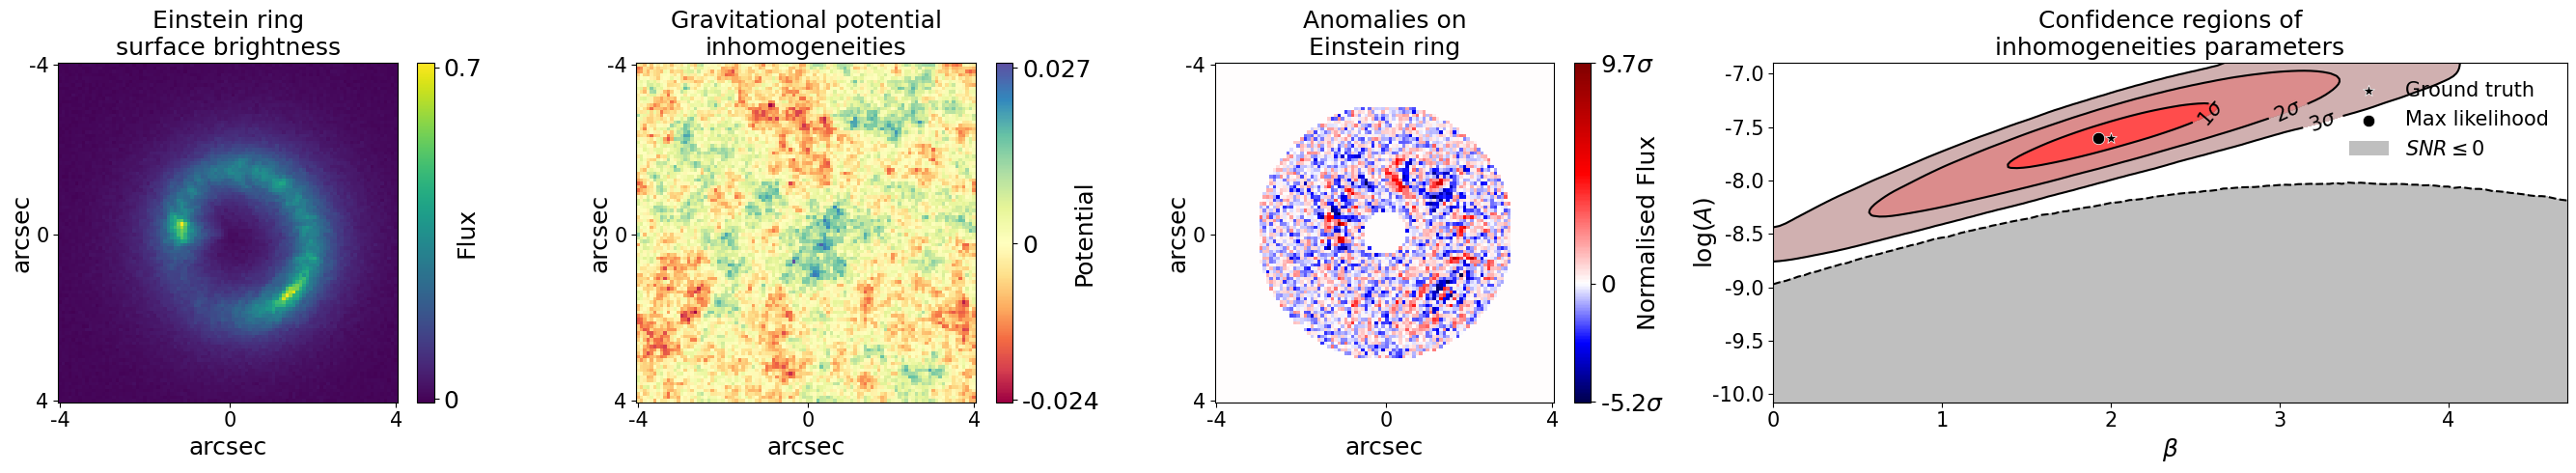

In [92]:
GRF_params=[-7.6,2]


get_GRF=Inference.GRF_getters(True)
GRF_potential=get_GRF(GRF_params,1)

true_logA_index=np.argmin(np.abs(logA_array-GRF_params[0]))
true_Beta_index=np.argmin(np.abs(Beta_array-GRF_params[1]))

likelihood,Confidence_grid,pred_logA_index,pred_Beta_index,logA_conf_regions,Beta_conf_regions=Inference_pipeline(data_spectrum,MU_tensor,Sigma_tensor)
logA_maxL_index,Beta_maxL_index=jnp.unravel_index(jnp.argmax(likelihood),likelihood.shape)

from matplotlib import gridspec
fig=plt.figure(figsize=(27,5))
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1])
ax=[]
for i in range(1):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]
    
ax=np.array(ax)

#ylabel=r"${\rm log}(A)$"+"={:.1f}".format(GRF_params[0])+'\n'+r'$\beta=$'+'{:.0f}           \n'.format(GRF_params[1])+'Phase={:.0f}    '.format(GRF_seed_index)
ylabel=''

manual_locations=[[(4,-10)],[(4,-10)],[(4,-10)]]
plot_line(ax[0],Observed_image,(Observed_image-Image_unperturbed_noiseless),GRF_potential,likelihood,Confidence_grid,SNR_grid,\
          true_logA_index,true_Beta_index,logA_maxL_index,Beta_maxL_index,ylabel,manual_locations,\
          logA_ind_lim=(0,128),Beta_ind_lim=(0,128),legend_flag=True)

plt.tight_layout(h_pad=3,w_pad=2)

### Three images on the left are observed Einstein ring, underlying potential inhomogeneties and surface brightness anomalies correspondingly. The one on the very right shows result of max-likelihood prediction of the parameters A,$\beta$ of the potential inhomogeneties

### Now let's make a separate prediction of A and $\beta$ and their confidence intervals

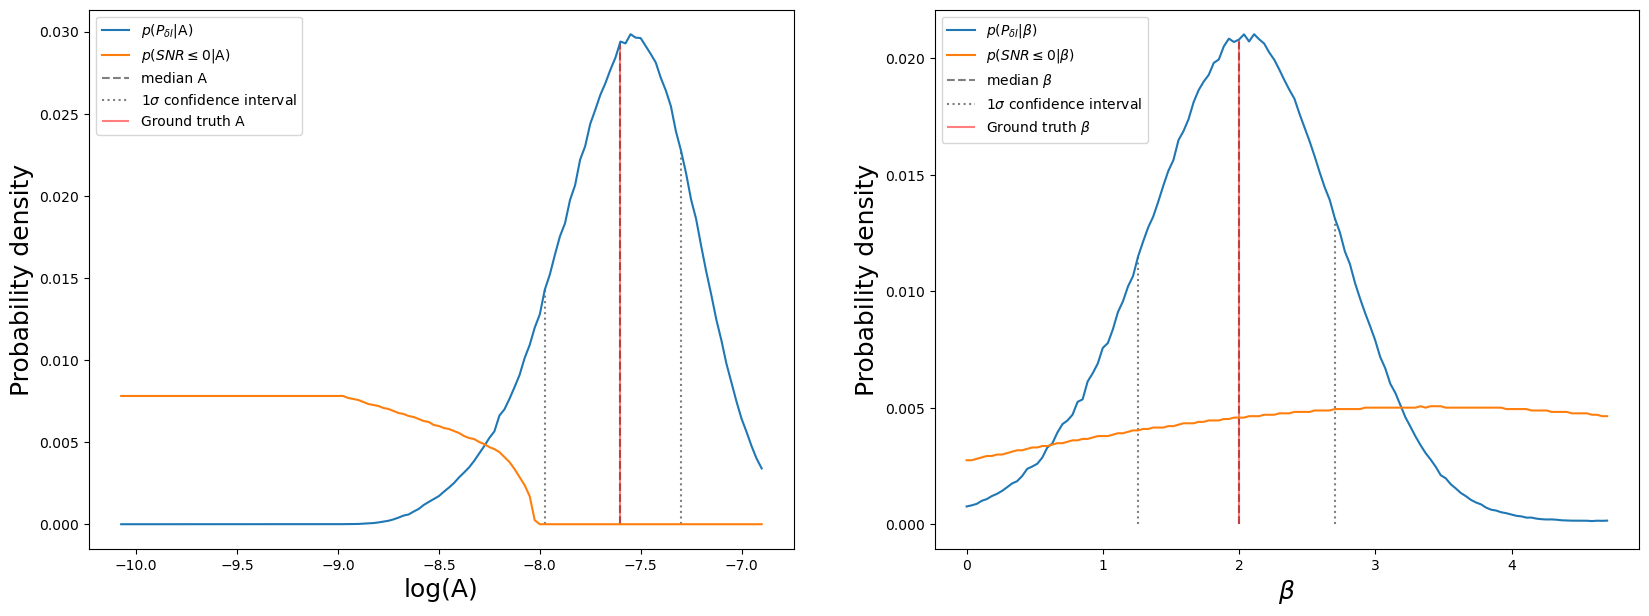

In [191]:
from GRF_perturbations.Modules.Inference import get_conf_intervals

res_matrix=get_conf_intervals(likelihood)
logA_pred_index,Beta_pred_index=res_matrix[0]
logA_conf_int_indices=res_matrix[1]
Beta_conf_int_indices=res_matrix[4]

logA_true_index=np.argmin(np.abs(logA_array+7.6))
Beta_true_index=np.argmin(np.abs(Beta_array-2))

title_arg=['A',r'$\beta$']
arg_array=[logA_array,Beta_array]
true_value=[-7.6,2]

fig,ax=plt.subplots(1,2,figsize=(20,7))

ax[0].set_xlabel('log(A)',fontsize=FS)
ax[1].set_xlabel(r'$\beta$',fontsize=FS)



for i in range(2):
    marginalization_index=np.logical_not(i).astype(int)
    likelihood_1d=likelihood.sum(axis=marginalization_index)/likelihood.sum()
    SNR_1d=(SNR_grid<=0).sum(axis=marginalization_index)/SNR_grid.size
    
    #Plots
    ax[i].plot(arg_array[i],likelihood_1d,label=r'$p(P_{\delta I}|$'+title_arg[i]+'$)$')
    ax[i].plot(arg_array[i],SNR_1d,label=r'$p(SNR \leq 0|$'+title_arg[i]+'$)$')
    
    #median and confidence intervals
    median_index=res_matrix[0,i]
    low_conf_index=res_matrix[1+i*3][0]
    high_conf_index=res_matrix[1+i*3][1]
    #median
    ax[i].vlines(arg_array[i][median_index],0,likelihood_1d[median_index],\
                 color='k',linestyle='dashed',alpha=0.5,label='median '+title_arg[i])
    #confidence intervals
    ax[i].vlines(arg_array[i][low_conf_index],0,likelihood_1d[low_conf_index],\
                color='k',linestyle='dotted',alpha=0.5,label=r'$1\sigma$'+' confidence interval')
    ax[i].vlines(arg_array[i][high_conf_index],0,likelihood_1d[high_conf_index],\
                color='k',linestyle='dotted',alpha=0.5)
    #Ground truth value
    true_index=np.argmin(np.abs(arg_array[i]-true_value[i]))
    ax[i].vlines(arg_array[i][true_index],0,likelihood_1d[true_index],\
                 color='r',alpha=0.5,label='Ground truth '+title_arg[i])
    ax[i].legend(loc='upper left')
    ax[i].set_ylabel('Probability density',fontsize=FS)

In [190]:
print('Ground truth: logA={:.1f}, Beta={:.0f}'.format(*true_value))

logA_interval=[logA_array[res_matrix[1,1]]-logA_array[res_matrix[0,0]],logA_array[res_matrix[0,0]]-logA_array[res_matrix[1,0]]]
Beta_interval=[Beta_array[res_matrix[4,1]]-Beta_array[res_matrix[0,1]],Beta_array[res_matrix[0,1]]-Beta_array[res_matrix[4,0]]]
print('Predicted logA: logA={:.2f} +{:.2f} -{:.2f}'.format(logA_array[res_matrix[0,0]],*logA_interval))
print('Predicted Beta: Beta={:.2f} +{:.2f} -{:.2f}'.format(Beta_array[res_matrix[0,1]],*Beta_interval))

Ground truth: logA=-7.6, Beta=2
Predicted logA: logA=-7.60 +0.30 -0.38
Predicted Beta: Beta=2.00 +0.70 -0.74


# Gradient descent-based inference

### Let's start with simplistic fitting. We will use only one GRF phase and Power spectrum estimated for the noise 

In [101]:
def get_noise_spectrum():
    noise_image=np.random.normal(0,scale=np.sqrt(Observation_conditions.noise_var))
    radial_spectrum=Inference.compute_radial_spectrum(noise_image)
    return radial_spectrum

Noise_radial_spectra=np.array([get_noise_spectrum() for i in tqdm(range(1000))])
Sigma_logN_noise=np.sqrt(np.power(np.log(Noise_radial_spectra)-np.log(Noise_radial_spectra).mean(axis=0),2).sum(axis=0)/(Noise_radial_spectra.shape[0]-1))

100%|███████████████████████████████████████| 1000/1000 [00:50<00:00, 19.91it/s]


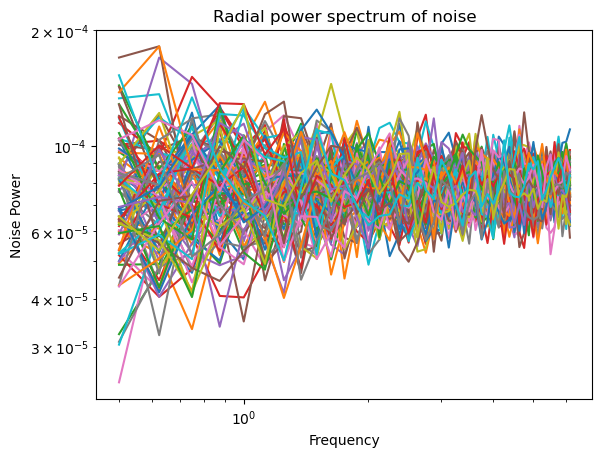

In [102]:
plt.loglog(Observation_conditions.frequencies,Noise_radial_spectra[:100].T)
plt.xlabel('Frequency')
plt.ylabel('Noise Power')
plt.title('Radial power spectrum of noise')
plt.show()

In [103]:
#Here we define a loss function and compile it for the data and for the noise
def Spectra_Loss(model_spectrum,data_spectrum,Sigma_logN):
    chi=(jnp.log(data_spectrum)-jnp.log(model_spectrum))/Sigma_logN
    
    return jnp.power(chi,2).mean()

Spectra_Loss_pure=jax.jit(lambda model_spectrum: Spectra_Loss(model_spectrum,data_spectrum,Sigma_logN_noise))

#Use only one GRF seed and the precompiled Noise-based spectrum loss function
GRF_Loss_pure=jax.jit(lambda GRF_params: Inference.GRF_Loss(GRF_params,GRF_seeds_number=2,Spectra_Loss_pure=Spectra_Loss_pure,Noise_flag=True))

In [56]:
    def Residual_spectrum_for_GRF(GRF_params,Fourier_phase,Noise=True):
        get_GRF=Inference.GRF_getters(False)

        GRF_potential=get_GRF(GRF_params,Fourier_phase)
        #We want noise to be random or at least different for every generated GRF
        #It should complicate computation of gradients, but we want to keep the function pure
        #+1 are needed cause those parameters are great or equal to zero
        noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(Fourier_phase[0,1].real*(1e+3)+1)*1e+5)).astype(int)

        simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
        simulated_image=simulate_perturbed_image(GRF_potential,Inference.Observation_conditions.kwargs_data,Noise,noise_seed)

        args_fit=Inference.differentiable_fit_image(simulated_image)

        simulate_unperturbed_image=Inference.Observation_conditions.unperturbed_image_getter
        fit_image=simulate_unperturbed_image(Inference.Observation_conditions.parameters.args2kwargs(args_fit),Noise_flag=False)

        residuals=simulated_image-fit_image
        spectrum=Inference.compute_radial_spectrum(residuals)
        return spectrum

In [82]:
q=Residual_spectrum_for_GRF(jnp.array([-7.6,1.]),Inference.Fourier_phase_tensor[0],True)

In [105]:
Inference.Residual_spectrum_for_GRF([-7.6,1.],Inference.Fourier_phase_tensor[0],Noise=True)

IndexError: arrays used as indices must be of integer (or boolean) type

In [83]:
jax.jit(lambda GRF_params: Inference.Residual_spectrum_for_GRF(GRF_params,Inference.Fourier_phase_tensor[0],Noise=True))(jnp.array([-7.6,1.]))

IndexError: arrays used as indices must be of integer (or boolean) type

In [41]:
GRF_Loss_pure(jnp.array([-7.6,1.]))

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=1/2)>
While tracing the function <lambda> at /Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Jax_Utils.py:63 for scan, this concrete value was not available in Python because it depends on the value of the argument '_'.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [21]:
Inference.Fourier_phase_tensor[:100].shape

(100, 100, 100)

In [22]:
Inference.Fourier_phase_tensor.shape

(100, 100, 100)